In [65]:
# Importing packages and ignoring warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Importing datasets and reading them through pandas package
color = sns.color_palette()
test_url = "https://raw.githubusercontent.com/artemedius/repo/main/houseprice%20forecast/test.csv"
train_url = "https://raw.githubusercontent.com/artemedius/repo/main/houseprice%20forecast/train.csv"
test = pd.read_csv(test_url)
train = pd.read_csv(train_url)

# Saving Id column and deleting from dataframes, they're irrelevant for regression
train_id = train['Id']
test_id = test['Id']
train = train.drop("Id", axis = 1)
test = test.drop("Id", axis = 1)

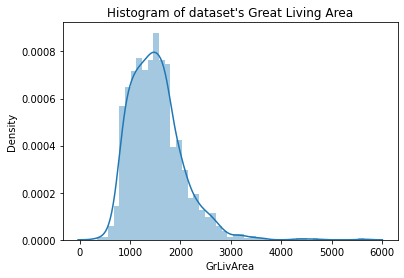

Skewness: 1.366560
Kurtosis: 4.895121


In [66]:
def hist_and_stats():
    sns.distplot(train['GrLivArea'])
    plt.title("Histogram of dataset's Great Living Area")
    plt.show()
    print("Skewness: %f" % train['GrLivArea'].skew())
    print("Kurtosis: %f" % train['GrLivArea'].kurt())
hist_and_stats()

Great Living Area is positively skewed, shows peakedness, therefore, deviates from normal distribution.
So, there must be outliers that we can eliminate.

In [67]:
# Detecting outliers for 
def detect_outlier(df):
    threshold=3
    mean = np.mean(df)
    std = np.std(df)
    outliers=[]

    for y in df:
        z_score= (y - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers
area_outliers = detect_outlier(train['GrLivArea'])
outlier_df = pd.DataFrame(train[train['GrLivArea'].isin(area_outliers)])

Outliers highlighted in orange: [3222, 3608, 3112, 3493, 3228, 4676, 3194, 3395, 4316, 3279, 3140, 3627, 4476, 3447, 5642, 3238]


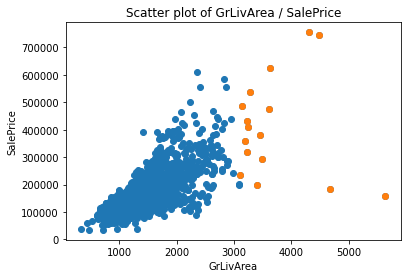

In [68]:
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
ax.scatter(x=outlier_df['GrLivArea'], y=outlier_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.title('Scatter plot of GrLivArea / SalePrice')
print(f'Outliers highlighted in orange: {area_outliers}')
plt.show()

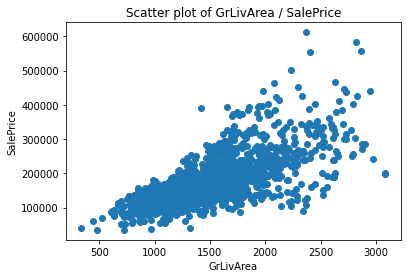

In [69]:
train = train[~train['GrLivArea'].isin(area_outliers)]
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.title('Scatter plot of GrLivArea / SalePrice')
plt.show()

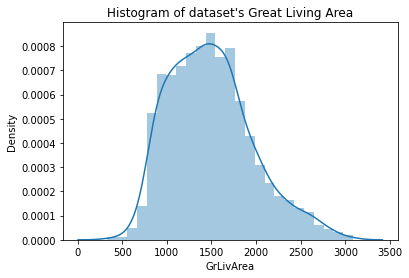

Skewness: 0.591685
Kurtosis: 0.094229


In [70]:
hist_and_stats()

Skewness and kurtosis have decreased significantly, but histogram still shows positive skewness. Anyway, GrLivArea and SalePrice have a linear relationship, what about others?